<a href="https://colab.research.google.com/github/MertKir-R/jigsaw_toxic_comment_classification/blob/main/RoBERTa_jigsaw_toxic_comment_classification_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

import torch.nn as nn

from transformers.modeling_outputs import SequenceClassifierOutput

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig, AutoModel, DataCollatorWithPadding
from datasets import Dataset

In [ ]:
from google.colab import drive
import sys

In [ ]:
model_path = "roberta-base" # dbmdz/bert-base-turkish-cased
tokenizer = AutoTokenizer.from_pretrained(model_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [ ]:
train_pd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jigsaw_toxic_comment_classification/train.csv')
test_pd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jigsaw_toxic_comment_classification/test.csv')

In [ ]:
train_pd.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test_pd.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
 8   text_length    159571 non-null  int64 
 9   token_length   159571 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 12.2+ MB


In [ ]:
def text_cleaning(text):
  if pd.isna(text):
        return ""
  text = str(text)
  text = unicodedata.normalize("NFKC", text) # unicodedata.normalize("NFKC", "①②③") converts to 123
  text = text.strip() # remove trailing and leading spaces
  return text

In [ ]:
train_pd['comment_text'] = train_pd['comment_text'].apply(text_cleaning)

In [ ]:
train_pd.loc[3,'comment_text']

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [ ]:
train_pd["token_length"] = train_pd["comment_text"].apply(
    lambda x: len(tokenizer(x)["input_ids"])
)

Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
train_pd["token_length"].max()

3229

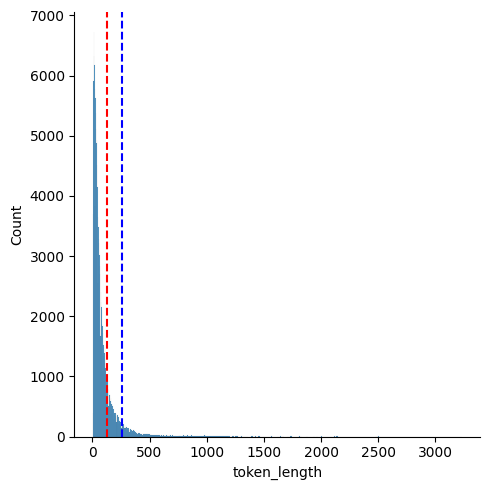

In [ ]:
g = sns.displot(data=train_pd, x="token_length")

g.refline(x=128, color="red", linestyle="--", label="128 tokens")
g.refline(x=256, color="blue", linestyle="--", label="256 tokens")

In [ ]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# float32 is important, loss function expects floats not integers
train_pd["labels"] = train_pd[label_cols].astype("float32").values.tolist()

In [ ]:
train_pd[train_pd["labels"].apply(sum) > 0] # 16225, total len = 159571

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,"[1.0, 1.0, 1.0, 0.0, 1.0, 0.0]"
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0]"
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0]"
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0]"
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


In [ ]:
train_pd[label_cols].mean() # severe_toxic, identity_hate etc appears only a few times.
# This might be a problem first just train a baseline model and then maybe fine tune threshold or apply weights in the loss function

,0
toxic,0.095844
severe_toxic,0.009996
obscene,0.052948
threat,0.002996
insult,0.049364
identity_hate,0.008805


In [ ]:
train_pd_final = train_pd[["id", "comment_text", "labels"]]

In [ ]:
train_pd_final.head()

,id,comment_text,labels
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [ ]:
train_df, val_df = train_test_split(
    train_pd_final,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [ ]:
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))

In [ ]:
train_dataset

Dataset({
    features: ['id', 'comment_text', 'labels'],
    num_rows: 127656
})

In [ ]:
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

In [ ]:
val_dataset

Dataset({
    features: ['id', 'comment_text', 'labels'],
    num_rows: 31915
})

# Modeling

In [ ]:
def preprocess_function(examples):
    return tokenizer(
        examples["comment_text"],
        truncation=True,
        max_length=128,
    )


train_tokenized = train_dataset.map(preprocess_function, batched=True)
val_tokenized = val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/127656 [00:00<?, ? examples/s]

Map:   0%|          | 0/31915 [00:00<?, ? examples/s]

Most of the time we use the pretrained tokenizer that comes with the pretrained model. We do not retrain the tokenizer for each dataset. That is because the model embeddings are tied to the tokenizer vocabulary Token ID 30522 means a very specific subword in RoBERTa. If you change the tokenizer token IDs change and embedding matrix no longer matches. So RoBERTa weights <-> RoBERTa tokenizer They are a pair. You can’t casually swap one.
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [ ]:
train_tokenized

Dataset({
    features: ['id', 'comment_text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 127656
})

In [ ]:
train_tokenized.features

{'id': Value('string'),
 'comment_text': Value('string'),
 'labels': List(Value('float64')),
 'input_ids': List(Value('int32')),
 'attention_mask': List(Value('int8'))}

In [ ]:
train_tokenized['comment_text'][10]

'"\n\nI have changed the headers to small letters, since I was basically demanded to. Now that I have done that, I would like those pictures to stay, with the headers in small letters the way they had been before you changed them. And since ""ballad"" appears twice and has a link on its second appearance, I am trying to rotate that to its first, but you must interfere again. Just keep the photos, I will change the headers back to the way they were before we both came along (in small letters), and then the Spice Girls section does not have to be constantly changed anymore.  "'

In [ ]:
train_tokenized['labels'][10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
sample = train_tokenized[10]
sample_tokens = tokenizer.convert_ids_to_tokens(sample["input_ids"])
sample_tokens
# Ġ means “space before token” and Ċ means “newline”; they’re RoBERTa’s equivalent of BERT’s ##

['<s>',
 '"',
 'Ċ',
 'Ċ',
 'I',
 'Ġhave',
 'Ġchanged',
 'Ġthe',
 'Ġheaders',
 'Ġto',
 'Ġsmall',
 'Ġletters',
 ',',
 'Ġsince',
 'ĠI',
 'Ġwas',
 'Ġbasically',
 'Ġdemanded',
 'Ġto',
 '.',
 'ĠNow',
 'Ġthat',
 'ĠI',
 'Ġhave',
 'Ġdone',
 'Ġthat',
 ',',
 'ĠI',
 'Ġwould',
 'Ġlike',
 'Ġthose',
 'Ġpictures',
 'Ġto',
 'Ġstay',
 ',',
 'Ġwith',
 'Ġthe',
 'Ġheaders',
 'Ġin',
 'Ġsmall',
 'Ġletters',
 'Ġthe',
 'Ġway',
 'Ġthey',
 'Ġhad',
 'Ġbeen',
 'Ġbefore',
 'Ġyou',
 'Ġchanged',
 'Ġthem',
 '.',
 'ĠAnd',
 'Ġsince',
 'Ġ""',
 'ball',
 'ad',
 '""',
 'Ġappears',
 'Ġtwice',
 'Ġand',
 'Ġhas',
 'Ġa',
 'Ġlink',
 'Ġon',
 'Ġits',
 'Ġsecond',
 'Ġappearance',
 ',',
 'ĠI',
 'Ġam',
 'Ġtrying',
 'Ġto',
 'Ġrotate',
 'Ġthat',
 'Ġto',
 'Ġits',
 'Ġfirst',
 ',',
 'Ġbut',
 'Ġyou',
 'Ġmust',
 'Ġinterfere',
 'Ġagain',
 '.',
 'ĠJust',
 'Ġkeep',
 'Ġthe',
 'Ġphotos',
 ',',
 'ĠI',
 'Ġwill',
 'Ġchange',
 'Ġthe',
 'Ġheaders',
 'Ġback',
 'Ġto',
 'Ġthe',
 'Ġway',
 'Ġthey',
 'Ġwere',
 'Ġbefore',
 'Ġwe',
 'Ġboth',
 'Ġcame',
 'Ġalong'

## Model Comparison

1st comparison: Freeze entire encoder (RoBERTa) only unfreeze the head and train. Compare the results with the custom head model. If custom head is clearly worse here, it’s unlikely to beat baseline later. Else it means that your custome head might be better than the existing one

2nd comparison: Unfreeze layer.11 (entire layer) + head in RoBERTa then compare the results with your custom head + unfreeze layer.11 model. Do this only if you get good results in 1st comparison else you just Unfreeze layer.11 (entire layer) + head and train it

In [ ]:
train_small = train_tokenized.shuffle(seed=42).select(range(40_000))
val_small   = val_tokenized.shuffle(seed=42).select(range(10_000))

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
id2label = {i: name for i, name in enumerate(label_cols)}
label2id = {name: i for i, name in enumerate(label_cols)}

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=len(label_cols),
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification",
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for name, param in model.named_parameters():
  print(name, param.requires_grad)

roberta.embeddings.word_embeddings.weight True
roberta.embeddings.position_embeddings.weight True
roberta.embeddings.token_type_embeddings.weight True
roberta.embeddings.LayerNorm.weight True
roberta.embeddings.LayerNorm.bias True
roberta.encoder.layer.0.attention.self.query.weight True
roberta.encoder.layer.0.attention.self.query.bias True
roberta.encoder.layer.0.attention.self.key.weight True
roberta.encoder.layer.0.attention.self.key.bias True
roberta.encoder.layer.0.attention.self.value.weight True
roberta.encoder.layer.0.attention.self.value.bias True
roberta.encoder.layer.0.attention.output.dense.weight True
roberta.encoder.layer.0.attention.output.dense.bias True
roberta.encoder.layer.0.attention.output.LayerNorm.weight True
roberta.encoder.layer.0.attention.output.LayerNorm.bias True
roberta.encoder.layer.0.intermediate.dense.weight True
roberta.encoder.layer.0.intermediate.dense.bias True
roberta.encoder.layer.0.output.dense.weight True
roberta.encoder.layer.0.output.dense.bia

Base transformer encoders (BERT, RoBERTa, etc.) return a contextual representation for every token in the sequence.
The representation of the first special token (BERT: "CLS", RoBERTa: "s") is commonly used as a sequence-level representation for classification tasks.

During self-attention, all tokens attend to all other tokens, including the first special token. As a result, the embedding of the first token aggregates information from the entire sequence and can serve as a summary of the text.

For base-sized models (e.g., bert-base, roberta-base), this sequence representation has 768 dimensions

When you use AutoModelForSequenceClassification you pass this 768 dim vector through dropout and a Linear(768 → num_labels)

Default HF Model:

[RoBERTa encoder]

  ↓

s embedding (768)

  ↓

Linear(768 → 6)

  ↓

logits

You can choose to add custom head on top of the base model like:

[RoBERTa encoder]
  
  ↓

embedding (768)

  ↓

Take average of embeddings of all tokens in a sequence

  ↓

Dropout

  ↓

Linear(768 → 256)

  ↓

ReLU

  ↓

Dropout

  ↓

Linear(256 → 6)

  ↓

logits


In [ ]:
class robertacustomhead(nn.Module):
  # custom_model = robertacustomhead() -> Python creates an object in memory
  # That object is passed into every method as the first argument, by convention named self
  def __init__(self, model_name: str, num_labels: int = 6, hidden_dim: int = 256, dropout: float = 0.1):

    super().__init__()
    self.config = AutoConfig.from_pretrained(model_name) # config = AutoConfig.from_pretrained(model_name) then config would be local
    # and disappear after the __init__ but this way you can call self.config from other methods as well
    self.encoder = AutoModel.from_pretrained(model_name, config=self.config)

    self.dropout1 = nn.Dropout(dropout)
    self.linear1 = nn.Linear(self.config.hidden_size, hidden_dim)
    self.relu = nn.ReLU()
    self.dropout2 = nn.Dropout(dropout)
    self.linear2 = nn.Linear(hidden_dim, num_labels)
    self.loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss internally applies sigmoid to our outputs so no need to do that transformation


  def freeze_encoder(self):
    for p in self.encoder.parameters():
      p.requires_grad = False

  def unfreeze_last_layer(self):
    for name, p in self.encoder.named_parameters():
      if "encoder.layer.11." in name:
        p.requires_grad = True


  def forward(self, input_ids=None, attention_mask=None, labels=None):

    outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
    # output.last_hidden_state (B, L, H) B = batch size (number of texts in the batch), L = sequence length (in our case 128),
    # H = hidden size (768 for roberta-base)
    # attention_mask (B,L) -> returns mask 1 for real tokens and 0 for padded tokens <PAD>
    hidden = outputs.last_hidden_state
    mask = attention_mask.unsqueeze(-1).float() # when you do unsqueeze(-1) you add another dimension (B, L)   → (B, L, 1)
    # Now each token has a scalar mask value. It is either 1 or 0
    masked_hidden = hidden * mask # this way 0s are not considered ie hidden states of <PAD> tokens are not considered
    # masked_hidden.sum(dim=1): Now you sum over the L dimension (tokens) (B, L, H) → (B, H) divided by number of real tokens mask.sum(dim=1) (B, 1)
    pooled = masked_hidden.sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)
    pooled = self.dropout1(pooled)
    pooled = self.linear1(pooled)
    pooled = self.relu(pooled)
    pooled = self.dropout2(pooled)
    logits = self.linear2(pooled)

    loss = None
    if labels is not None:
      loss = self.loss_fn(logits, labels.float())

    return SequenceClassifierOutput(loss=loss, logits=logits)





In [ ]:
custom_model = robertacustomhead(
    model_name="roberta-base",
    num_labels=6
)

custom_model.freeze_encoder()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for name, param in model.named_parameters():
  if "classifier" in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

In [ ]:
base_args = dict(
    seed=42,
    # fixed compute budget
    max_steps=600,    # there will 600 weight updates it is fixed not dependent on the batch size and epoch numbers
    warmup_ratio=0.06,
    # batch & speed
    per_device_train_batch_size=16, # How many examples are processed per forward/backward pass on your GPU during training. drop to 8 if OOM
    per_device_eval_batch_size=32, # Batch size for evaluation only, no gradients thus consumes less memory
    gradient_accumulation_steps=1,  # set to 2 if you had to drop batch_size
    fp16=True,
    # optimizer / regularization
    learning_rate=5e-4,            # higher is OK for head-only
    weight_decay=0.01,
    # logging/eval
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,
    # avoid time + disk
    save_strategy="no",            # don’t checkpoint during A/B
    report_to="none",
)

In [ ]:
base_args

{'seed': 42,
 'max_steps': 600,
 'warmup_ratio': 0.06,
 'per_device_train_batch_size': 16,
 'per_device_eval_batch_size': 32,
 'gradient_accumulation_steps': 1,
 'fp16': True,
 'learning_rate': 0.0005,
 'weight_decay': 0.01,
 'logging_steps': 50,
 'eval_strategy': 'steps',
 'eval_steps': 100,
 'save_strategy': 'no',
 'report_to': 'none'}

In [ ]:
training_args_base = TrainingArguments(
    output_dir="ab_base_head",
    **base_args
)

training_args_custom = TrainingArguments(
    output_dir="ab_custom_head",
    **base_args
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred  # logits: (N,6), labels: (N,6)
    probs = 1 / (1 + np.exp(-logits))  # sigmoid

    # macro average across 6 labels
    macro_auc = roc_auc_score(labels, probs, average="macro")

    return {"macro_roc_auc": macro_auc}

In [ ]:
from transformers import set_seed
set_seed(42)

trainer1 = Trainer(
    model=model, # Trainer never calls forward() explicitly it calls the model, and PyTorch calls forward() for you.
    args=training_args_base,
    train_dataset=train_small,
    eval_dataset=val_small,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer1.train()
base_metrics = trainer1.evaluate()

/tmp/ipython-input-3080465004.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1 = Trainer(


Step,Training Loss,Validation Loss,Macro Roc Auc
100,0.168100,0.131879,0.711815
200,0.136300,0.123011,0.838792
300,0.126000,0.115061,0.887828
400,0.123300,0.108285,0.922187
500,0.100400,0.102973,0.928038
600,0.113200,0.100940,0.931442


In [ ]:
set_seed(42)

trainer2 = Trainer(
    model=custom_model,
    args=training_args_custom,
    train_dataset=train_small,
    eval_dataset=val_small,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer2.train()
custom_metrics = trainer2.evaluate()

/tmp/ipython-input-1547462793.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer2 = Trainer(


Step,Training Loss,Validation Loss,Macro Roc Auc
100,0.154500,0.118286,0.833021
200,0.107300,0.094583,0.924916
300,0.091600,0.082887,0.940116
400,0.085800,0.078256,0.947158
500,0.065900,0.075797,0.948655
600,0.081600,0.074769,0.949590


Model with masked mean pooling + linear layer performed better than the base model head. We will compare the model performances when layer 11 is unfreezed.

In [ ]:
custom_model = robertacustomhead(
    model_name="roberta-base",
    num_labels=6
)

custom_model.freeze_encoder()

custom_model.unfreeze_last_layer()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=len(label_cols),
                                                           id2label=id2label, label2id=label2id,
                                                           problem_type="multi_label_classification",)

for name, param in model.named_parameters():
  if "layer.11" in name or "classifier" in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
base_args_unfreeze = dict(
    seed=42,
    # fixed compute budget
    max_steps=400,    # there will 400 weight updates it is fixed not dependent on the batch size and epoch numbers
    warmup_ratio=0.06,
    # batch & speed
    per_device_train_batch_size=16, # How many examples are processed per forward/backward pass on your GPU during training. drop to 8 if OOM
    per_device_eval_batch_size=32, # Batch size for evaluation only, no gradients thus consumes less memory
    gradient_accumulation_steps=1,  # set to 2 if you had to drop batch_size
    fp16=True,
    # optimizer / regularization
    learning_rate=1e-4,            # reduced lr when layer 11 is unfreezed
    weight_decay=0.01,
    # logging/eval
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,
    # avoid time + disk
    save_strategy="no",            # don’t checkpoint during A/B
    report_to="none",
)

In [ ]:
training_args_base_unfreeze = TrainingArguments(
    output_dir="ab_base_head_unfreeze",
    **base_args_unfreeze
)

training_args_custom_unfreeze = TrainingArguments(
    output_dir="ab_custom_head_unfreeze",
    **base_args_unfreeze
)

In [ ]:
set_seed(42)

trainer1_unfreeze = Trainer(
    model=model, # Trainer never calls forward() explicitly it calls the model, and PyTorch calls forward() for you.
    args=training_args_base_unfreeze,
    train_dataset=train_small,
    eval_dataset=val_small,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer1_unfreeze.train()
base_metrics_unfreeze = trainer1_unfreeze.evaluate()

/tmp/ipython-input-3339435134.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1_unfreeze = Trainer(


Step,Training Loss,Validation Loss,Macro Roc Auc
100,0.145300,0.109852,0.911418
200,0.075000,0.061745,0.955553
300,0.066000,0.055710,0.965827
400,0.058900,0.054967,0.965876


In [ ]:
set_seed(42)

trainer2_unfreeze = Trainer(
    model=custom_model,
    args=training_args_custom_unfreeze,
    train_dataset=train_small,
    eval_dataset=val_small,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer2_unfreeze.train()
custom_metrics_unfreeze = trainer2_unfreeze.evaluate()

/tmp/ipython-input-2197599493.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer2_unfreeze = Trainer(


Step,Training Loss,Validation Loss,Macro Roc Auc
100,0.129900,0.086186,0.950637
200,0.068900,0.060126,0.966751
300,0.066100,0.056350,0.969511
400,0.061600,0.055119,0.970279


Custom head where we took the mean of hidden states of each token instead of using hidden state of s performed better when layer 11 is unfrozen. Thus we will proceed with custom head model.

## Hyperparameter Tuning

Now we can proceed with fine tuning learning rate, max sequence length, batch size.

In [ ]:
lr_list = [3e-5, 1e-4, 3e-4]
results = dict()

for i in lr_list:
  output_dir_name = f"ab_custom_head_tuning_lr{i:.0e}"
  base_args_tuning = dict(
      seed=42,
      # fixed compute budget
      max_steps=400,    # there will 400 weight updates it is fixed not dependent on the batch size and epoch numbers
      warmup_ratio=0.06,
      # batch & speed
      per_device_train_batch_size=16, # How many examples are processed per forward/backward pass on your GPU during training. drop to 8 if OOM
      per_device_eval_batch_size=32, # Batch size for evaluation only, no gradients thus consumes less memory
      gradient_accumulation_steps=1,  # set to 2 if you had to drop batch_size
      fp16=True,
      # optimizer / regularization
      learning_rate=i,            # reduced lr when layer 11 is unfreezed
      weight_decay=0.01,
      # logging/eval
      logging_steps=50,
      eval_strategy="steps",
      eval_steps=100,
      # avoid time + disk
      save_strategy="no",            # don’t checkpoint during A/B
      report_to="none",
  )

  custom_model = robertacustomhead(
    model_name="roberta-base",
    num_labels=6
  )

  custom_model.freeze_encoder()

  custom_model.unfreeze_last_layer()

  training_args_custom_tuning = TrainingArguments(
      output_dir=output_dir_name,
      **base_args_tuning
  )

  trainertuning = Trainer(
      model=custom_model,
      args=training_args_custom_tuning,
      train_dataset=train_small,
      eval_dataset=val_small,
      tokenizer=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics,
  )

  trainertuning.train()
  custom_metrics_tuning = trainertuning.evaluate()
  results[i] = custom_metrics_tuning


print(results)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-144146667.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainertuning = Trainer(


Step,Training Loss,Validation Loss,Macro Roc Auc
100,0.245200,0.141818,0.765197
200,0.127800,0.117142,0.917457
300,0.111900,0.103239,0.944380
400,0.110700,0.098924,0.949004


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-144146667.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainertuning = Trainer(


Step,Training Loss,Validation Loss,Macro Roc Auc
100,0.129900,0.086186,0.950637
200,0.068900,0.060126,0.966751
300,0.066100,0.056350,0.969511
400,0.061600,0.055119,0.970279


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-144146667.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainertuning = Trainer(


Step,Training Loss,Validation Loss,Macro Roc Auc
100,0.075500,0.064815,0.965573
200,0.067800,0.054924,0.967459
300,0.061000,0.052413,0.969681
400,0.057200,0.052031,0.970618


{3e-05: {'eval_loss': 0.09892363846302032, 'eval_macro_roc_auc': 0.9490042042118483, 'eval_runtime': 16.1406, 'eval_samples_per_second': 619.555, 'eval_steps_per_second': 19.392, 'epoch': 0.16}, 0.0001: {'eval_loss': 0.05511872097849846, 'eval_macro_roc_auc': 0.9702785271847453, 'eval_runtime': 16.088, 'eval_samples_per_second': 621.582, 'eval_steps_per_second': 19.456, 'epoch': 0.16}, 0.0003: {'eval_loss': 0.05203111469745636, 'eval_macro_roc_auc': 0.9706181154912431, 'eval_runtime': 15.9587, 'eval_samples_per_second': 626.616, 'eval_steps_per_second': 19.613, 'epoch': 0.16}}


3e-4 performed the best we will proceed with it

compare max sequence length performances

In [ ]:
def preprocess_function256(examples):
    return tokenizer(
        examples["comment_text"],
        truncation=True,
        max_length=256,
    )


train_tokenized256 = train_dataset.map(preprocess_function256, batched=True)
val_tokenized256 = val_dataset.map(preprocess_function256, batched=True)

train_small256 = train_tokenized256.shuffle(seed=42).select(range(40_000))
val_small256   = val_tokenized256.shuffle(seed=42).select(range(10_000))


base_args_seq256 = dict(
      seed=42,
      # fixed compute budget
      max_steps=400,    # there will 400 weight updates it is fixed not dependent on the batch size and epoch numbers
      warmup_ratio=0.06,
      # batch & speed
      per_device_train_batch_size=8, # How many examples are processed per forward/backward pass on your GPU during training. drop to 8 if OOM
      per_device_eval_batch_size=32, # Batch size for evaluation only, no gradients thus consumes less memory
      gradient_accumulation_steps=2,  # set to 2 if you had to drop batch_size
      fp16=True,
      # optimizer / regularization
      learning_rate=3e-4,
      weight_decay=0.01,
      # logging/eval
      logging_steps=50,
      eval_strategy="steps",
      eval_steps=100,
      # avoid time + disk
      save_strategy="no",            # don’t checkpoint during A/B
      report_to="none",
  )

custom_model = robertacustomhead(
    model_name="roberta-base",
    num_labels=6
  )

custom_model.freeze_encoder()

custom_model.unfreeze_last_layer()

training_args_custom_seq256 = TrainingArguments(
      output_dir="ab_custom_head_seq256",
      **base_args_seq256
  )

trainertuning_seq256 = Trainer(
      model=custom_model,
      args=training_args_custom_seq256,
      train_dataset=train_small256,
      eval_dataset=val_small256,
      tokenizer=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics,
  )

trainertuning_seq256.train()
custom_metrics_tuning_seq256 = trainertuning_seq256.evaluate()

Map:   0%|          | 0/127656 [00:00<?, ? examples/s]

Map:   0%|          | 0/31915 [00:00<?, ? examples/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1803501280.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainertuning_seq256 = Trainer(


Step,Training Loss,Validation Loss,Macro Roc Auc
100,0.074400,0.062148,0.964490
200,0.069800,0.055276,0.966718
300,0.061300,0.052085,0.969987
400,0.057200,0.051314,0.970879


when we increased sequence length to 256 auc did not improve that big to sacrifice some computational cost. Because of this we will proceed with sequence length 128

## Final Model

final model training on whole dataset

In [ ]:
base_args_final = dict(
      seed=42,
      # fixed compute budget
      num_train_epochs=3,    # there will be 3 epochs, model will see all the data 3 times
      warmup_ratio=0.06,
      # batch & speed
      per_device_train_batch_size=16, # How many examples are processed per forward/backward pass on your GPU during training. drop to 8 if OOM
      per_device_eval_batch_size=32, # Batch size for evaluation only, no gradients thus consumes less memory
      gradient_accumulation_steps=1,  # set to 2 if you had to drop batch_size
      fp16=True,
      # optimizer / regularization
      learning_rate=3e-4,            # reduced lr when layer 11 is unfreezed
      weight_decay=0.01,
      # logging/eval
      logging_steps=50,
      eval_strategy="epoch",
      # avoid time + disk
      save_strategy="epoch",
      load_best_model_at_end=True,
      metric_for_best_model="eval_macro_roc_auc",
      report_to="none",
  )

custom_model = robertacustomhead(
    model_name="roberta-base",
    num_labels=6
  )

custom_model.freeze_encoder()

custom_model.unfreeze_last_layer()

training_args_custom_final = TrainingArguments(
      output_dir="custom_head_jigsaw_final",
      **base_args_final
  )

trainer_final = Trainer(
      model=custom_model,
      args=training_args_custom_final,
      train_dataset=train_tokenized,
      eval_dataset=val_tokenized,
      tokenizer=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics,
  )

trainer_final.train()
custom_metrics_final = trainer_final.evaluate()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-427339762.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_final = Trainer(


Epoch,Training Loss,Validation Loss,Macro Roc Auc
1,0.042600,0.042657,0.986637
2,0.044500,0.040972,0.989324
3,0.049400,0.039604,0.989752


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


pred_out = trainer_final.predict(val_tokenized)
logits = pred_out.predictions          # (N, 6)
labels = pred_out.label_ids

probs = sigmoid(logits)

threshold = 0.3
is_all_zero = (labels.sum(axis=1) == 0)

max_prob = probs.max(axis=1)
max_label = probs.argmax(axis=1)

false_alarm_idx = np.where(is_all_zero & (max_prob >= threshold))[0]

sorted_idx = false_alarm_idx[np.argsort(-max_prob[false_alarm_idx])]

top_k = 10
for j in sorted_idx[:top_k]:
    print("="*80)
    print("val index:", int(j))
    print("true labels:", labels[j].tolist())
    print("max prob:", float(max_prob[j]), "at label:", int(max_label[j]))
    print("probs:", np.round(probs[j], 4).tolist())
    print("text:", val_tokenized[int(j)]["comment_text"][:500])

val index: 27321
true labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
max prob: 0.9964619278907776 at label: 0
probs: [0.9965000152587891, 0.19380000233650208, 0.9577999711036682, 0.001500000013038516, 0.7968999743461609, 0.01759999990463257]
text: RACECARS, LASERS, AEROPHANES, IT'S A DUCK-BLUR
val index: 14897
true labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
max prob: 0.9914224743843079 at label: 0
probs: [0.9914000034332275, 0.13199999928474426, 0.741100013256073, 0.016200000420212746, 0.8763999938964844, 0.4097999930381775]
text: (YOU ARE FAGS) 

 I AM LEVEL 2 OF LEVEL 2 AND YOU ARE STILL FAGS 

Menergy Energy for MEN
val index: 25671
true labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
max prob: 0.9872773289680481 at label: 0
probs: [0.9872999787330627, 0.0544000007212162, 0.861299991607666, 0.001500000013038516, 0.7522000074386597, 0.462799996137619]
text: voidid or whatever his name is. 

hey voidid called me a nobody. so screw him.and he was rippin brock lesnar. i dont go on his gay steve blackman art

In [ ]:
val_df.iloc[29012]['comment_text']

"Wimt (what a gay name that is!  you must be British!), when was the last time someone did what you told them?!  I bet it's never happened!"

In [ ]:
val_df.iloc[29012]['labels']

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

My model found this text to be toxic with prob 0.97 and 0.62 insult, identity hate with prob 0.63. It appears there involves some racism towards British people so it seems like my model did a good job, probably the labels were wrong it does not make sense for them to be 0

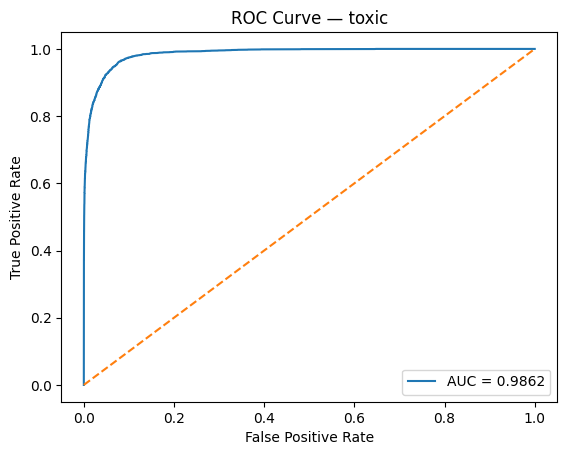

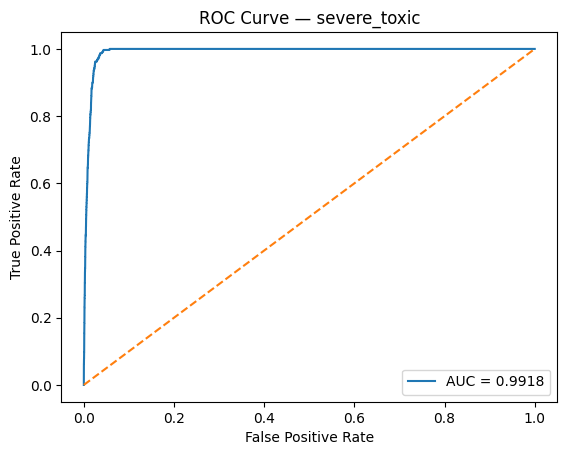

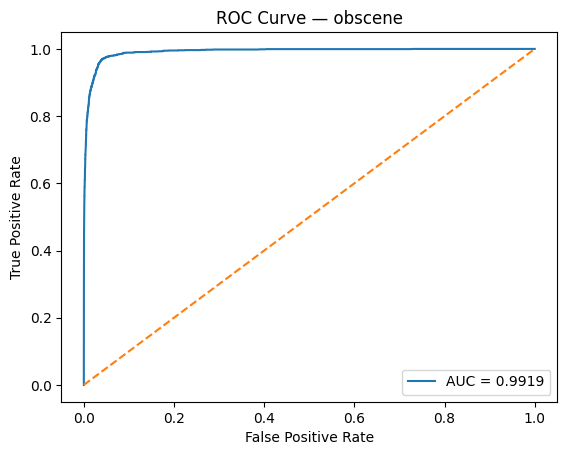

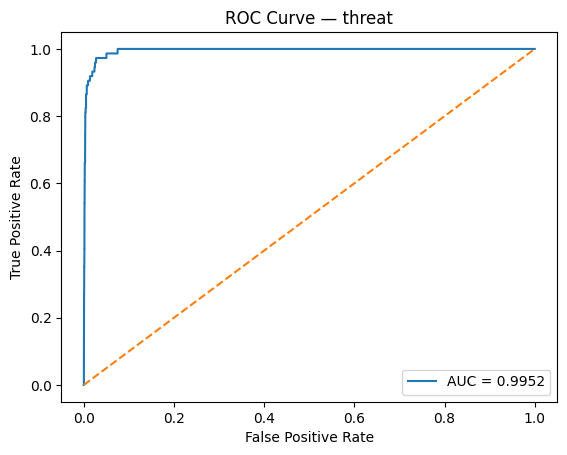

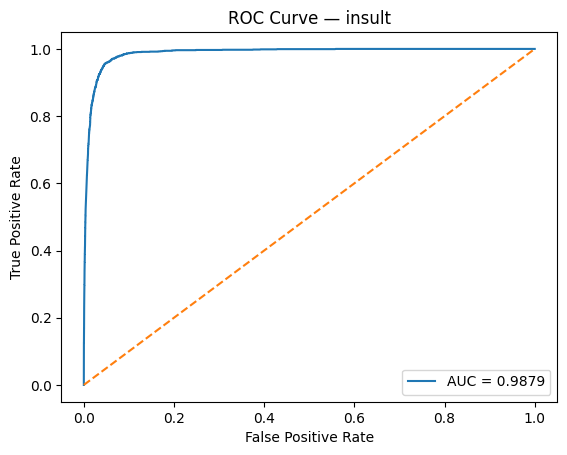

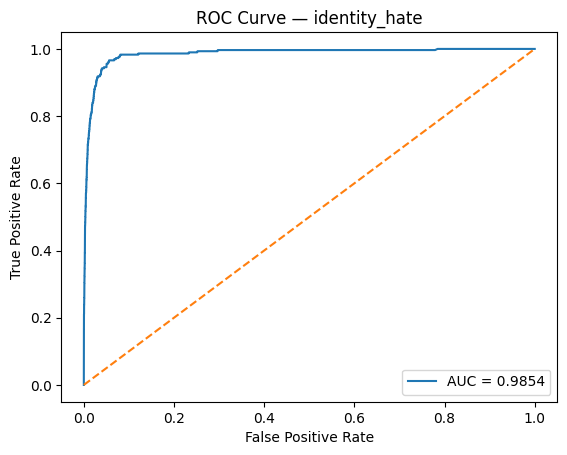

In [ ]:

label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for k in range(6):
    y_true = labels[:, k] # take true values in each label
    y_score = probs[:, k]

    # roc_curve expects at least one positive and one negative in y_true so we are looking if there is both 0 and 1 under that label
    if len(np.unique(y_true)) < 2:
        continue

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {label_cols[k]}")
    plt.legend(loc="lower right")
    plt.show()

## Test

In [ ]:
label_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

# Keep ids
test_ids = test_pd["id"].values
test_dataset = Dataset.from_pandas(test_pd)

test_tokenized = test_dataset.map(preprocess_function, batched=True)

pred_out_test = trainer_final.predict(test_tokenized)
logits_test = pred_out_test.predictions           # shape (N, 6)

probs_test = sigmoid(logits_test)

Map:   0%|          | 0/153164 [00:00<?, ? examples/s]

In [ ]:
submission = pd.DataFrame(probs_test, columns=label_cols)
submission.insert(0, "id", test_ids) # added the ids

In [ ]:
submission[:5]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.997030,3.145767e-01,0.975437,1.956867e-02,0.951233,0.772187
1,0000247867823ef7,0.000088,2.017645e-08,0.000028,2.135542e-07,0.000006,0.000002
2,00013b17ad220c46,0.000033,4.618434e-08,0.000037,4.476340e-08,0.000004,0.000001
3,00017563c3f7919a,0.000025,6.513037e-08,0.000027,5.570894e-08,0.000004,0.000001
4,00017695ad8997eb,0.000586,9.329492e-08,0.000067,6.695539e-06,0.000023,0.000015


In [ ]:
submission.to_csv(
    "/content/drive/MyDrive/jigsaw_submission.csv",
    index=False
)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.997030,3.145767e-01,0.975437,1.956867e-02,0.951233,0.772187
1,0000247867823ef7,0.000088,2.017645e-08,0.000028,2.135542e-07,0.000006,0.000002
2,00013b17ad220c46,0.000033,4.618434e-08,0.000037,4.476340e-08,0.000004,0.000001
3,00017563c3f7919a,0.000025,6.513037e-08,0.000027,5.570894e-08,0.000004,0.000001
4,00017695ad8997eb,0.000586,9.329492e-08,0.000067,6.695539e-06,0.000023,0.000015


Submission made to kaggle jigsaw competition page, 0.9798 AUC for public score, 0.9813 AUC for private is achieved.